In [1]:
import tools
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor



In [2]:
def _bipolar_reference(data_arg):
    (n_time_samples, n_channels) = data_arg.shape
    # separate contact names
    leads = []
    contacts = []
    for i in data_arg.columns:
        if i in ['C3', 'C4', 'ECG1', 'ECG2']:
            n_channels = n_channels - 1
            continue

        M = re.match(r"(\D+)(\d+)", i)
        if M is None:
            n_channels = n_channels - 1
            continue
        leads.append(M.group(1).replace("EEG", "").strip())
        contacts.append(int(M.group(2)))

    leads_contacts = [f"{i}{j:02d}" for i, j in zip(leads, contacts)]
    col_names = []
    data_entries = []
    # find montage channel before
    for index in range(n_channels - 1):
        lead = leads[index]
        contact = contacts[index]

        next_lead_contact = f"{lead}{(contact + 1):02d}"

        try:
            next_index = leads_contacts.index(next_lead_contact)
        except ValueError:
            continue

        col_names.append(f"{leads_contacts[index]}-{leads_contacts[next_index]}")
        data_entries.append(data_arg.iloc[:, index] - data_arg.iloc[:, next_index])
    
    data_entries = np.array(data_entries).T
    bipolar_data = pd.DataFrame(data_entries, columns=col_names, index=data_arg.index)

    return bipolar_data


In [3]:
# username = 'pattnaik'
# pwd_bin_file = '/mnt/local/gdrive/public/USERS/pattnaik/pre-ictal-similarity/code/pat_ieeglogin.bin'

username = 'igvilla'
pwd_bin_file = '/gdrive/public/USERS/igvilla/igv_ieeglogin.bin'

###

# practice of a random new time:
# start_time_sec = 315961
# end_time_sec = 315961 + 60 

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

### 

# LB3_001_phaseII, seizure 1:
start_time_sec = 425585.079036 - 60 # showing starting 1 minute before the seizure
end_time_sec = 425585.079036 + 72.0709640000131
# LB3_001_phaseII, seizure 1:
iEEG_filename = 'LB3_004'
start_time_usec = start_time_sec * 1e6
end_time_usec = end_time_sec * 1e6




In [4]:
data, fs = tools.get_iEEG_data(username, pwd_bin_file, iEEG_filename, start_time_usec, end_time_usec, select_electrodes=np.arange(25))



In [5]:
start_time_usec, end_time_usec

(425525079036.0, 425657150000.0)

In [6]:
end_time_sec - start_time_sec

132.0709640000132

In [7]:
# extract dims
(n_samples, n_channels) = data.shape

# set time array
t_sec = np.linspace(start_time_sec, end_time_sec, n_samples)

# remove 60Hz noise
b, a = iirnotch(F0, Q, fs)
signal_filt = filtfilt(b, a, data, axis=0)

# bandpass between 1 and 120Hz
bandpass_b, bandpass_a = butter(3, [1, 120], btype='bandpass', fs=fs)
signal_filt = filtfilt(bandpass_b, bandpass_a, signal_filt, axis=0)

# format resulting data into pandas DataFrame
signal_filt = pd.DataFrame(signal_filt, columns=data.columns)
signal_filt.index = pd.to_timedelta(t_sec, unit="S")

signal_ref = _bipolar_reference(signal_filt)

In [8]:
np.size(signal_ref)

304299

In [9]:
signal_ref

,A01-A02,EKG01-EKG02,F03-F04,F07-F08,F08-F09,F09-F10,Fp01-Fp02,O01-O02,P03-P04
4 days 22:12:05.079036,-2.549635,-122.239485,7.025617,0.732717,-122.368701,118.574860,4.443971,1.396957,-0.494176
4 days 22:12:05.082942269,3.173079,442.395430,-3.603099,12.636443,436.371204,-438.880235,24.423917,-4.294518,3.345038
4 days 22:12:05.086848539,16.538651,1340.090590,-19.083237,18.501935,1338.746710,-1338.200630,67.175760,-9.951558,8.223531
4 days 22:12:05.090754808,14.524816,968.869099,-8.711231,10.715031,974.197996,-969.565216,57.815203,-4.450491,5.020377
4 days 22:12:05.094661077,0.471502,19.579062,6.575783,3.634459,21.694930,-13.990603,13.340051,3.107330,-0.351586
...,...,...,...,...,...,...,...,...,...
4 days 22:14:17.134374923,1.777112,-0.532377,-11.913351,4.401319,10.798557,-1.081370,-54.000800,-13.478588,3.419232
4 days 22:14:17.138281192,9.988947,618.525408,-15.085414,18.140199,625.960677,-627.050902,-32.705369,-18.782985,11.075500
4 days 22:14:17.142187461,14.078051,978.472210,-19.508663,15.331628,990.211164,-991.623965,-27.297911,3.980344,12.141331
4 days 22:14:17.146093731,4.885088,413.034183,-8.788484,1.744563,428.105210,-424.701183,-71.275426,16.733690,13.758450


In [10]:
signal_ref.to_hdf(f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5", key='ieeg')

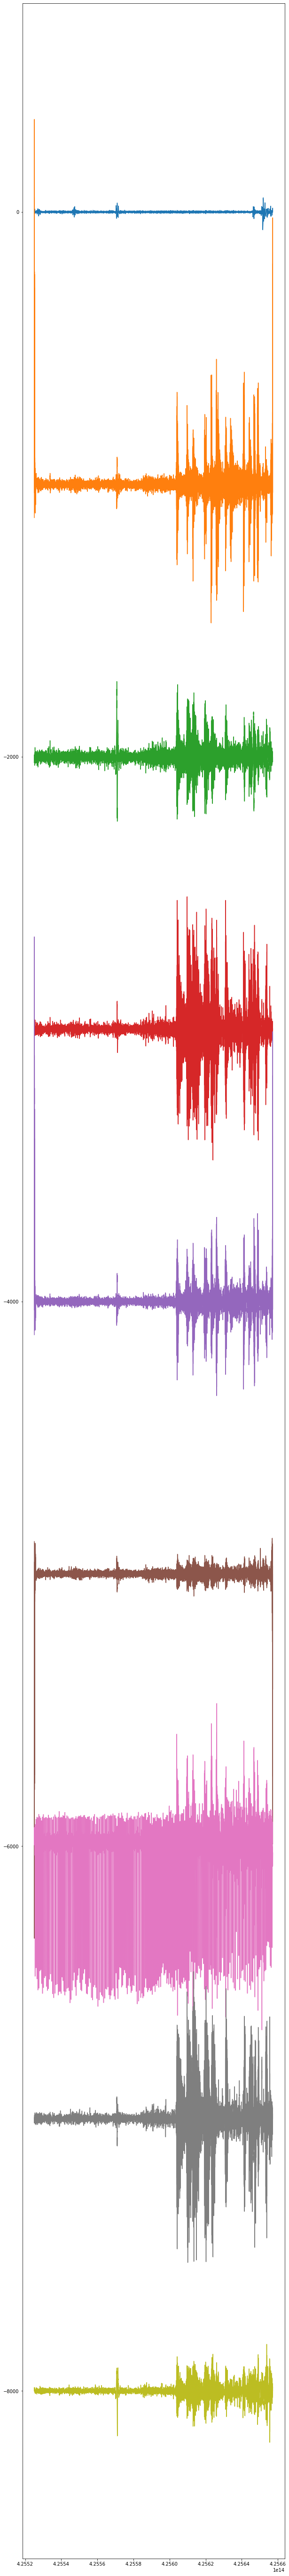

In [11]:
# changed from 34 to 9
plt.figure(figsize=(10, 100)); plt.plot(signal_ref.iloc[:, 0:9] + np.arange(9)*-1000)